# Text Mining Final Project: A Book Recommender System
__Andrea Valderrey, Tereza Odysseos, Anne Marijn Coers & Clarice van der Paardt__

This project aims to compare the genre relevance of recommendations generated by three different recommender systems (description-based, rating-based, and combined) with genres of recommendations from Goodreads. Our motivation lies in producing a recommendation system that aligns in terms of genre with Goodreads' system, a widely used platform for book recommendations. Using the extensive Goodreads book dataset from Kaggle, containing over 10 million entries, we will preprocess the data and develop three distinct models. By evaluating the effectiveness of each model in providing personalized book recommendations aligned with user genre preferences, we aim to identify which model performs best in this task. This comparison will shed light on which feature (description or ratings) contributes more significantly to the quality of recommendations, thereby providing insights for optimizing recommendation systems to improve genre alignment.

This notebook is divided into the following parts:
* Data loading and general preprocessing
* __Model 1__: Description-based model
* __Model 2__: Rating-based model (weighed)
* __Model 3__: Combination model
* Model assessment
* Conclusion

### To do:
* First code block for 'language processing' heading => what does that mean?
* Maybe we should have 1 helper function to print the top 5 most related books?

## Data Loading & General Preprocessing

In this part, we first load the required data and format them. We perform a brief exploration of the data to gain insights in what we will be working with.

As not all csv files in our dataset have the description column required for one of our models and given that we intend to train all our models on the same data, we use a specific file that meets our requirements. The ratings of all the books are provided in different files. However, the ratings of the books are not aligned with the book files. Therefore, we have concatenated all the files of the ratings in order to ascertain to have covered all the books in our books file.

In [82]:
# Imports
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import seaborn as sns

### Books File:

In [83]:
# Importing the books file and taking a first look:
books_df = pd.read_csv('book600k-700k.csv', delimiter= ",")
print(f"The books data frame has {books_df.shape[0]} rows and {books_df.shape[1]} columns.")
books_df.head()

The books data frame has 55156 rows and 19 columns.


,Id,Name,Authors,ISBN,Rating,PublishYear,PublishMonth,PublishDay,Publisher,RatingDist5,RatingDist4,RatingDist3,RatingDist2,RatingDist1,RatingDistTotal,CountsOfReview,Language,pagesNumber,Description
0,600000,"Lessons Learned (Great Chefs, #2)",Nora Roberts,037351025X,3.74,1993,15,2,Silhouette,5:947,4:1016,3:1061,2:287,1:63,total:3374,86,eng,250,LESSONS LEARNED...<br /><br />Coordinating the...
1,600001,Walking by Faith: Lessons Learned in the Dark,Jennifer Rothschild,0633099325,4.27,2003,1,1,Lifeway Church Resources,5:367,4:246,3:109,2:22,1:5,total:749,7,NaN,112,"At the age of fifteen, Jennifer Rothschild con..."
2,600003,Better Health in Africa: Experience and Lesson...,World Bank Group,0821328174,5.00,1994,1,1,World Bank Publications,5:1,4:0,3:0,2:0,1:0,total:1,1,NaN,240,NaN
3,600004,"The Blended Learning Book: Best Practices, Pro...",Josh Bersin,0787972967,4.10,2004,1,10,Pfeiffer,5:8,4:6,3:6,2:0,1:0,total:20,3,NaN,319,<i>The Blended Learning Book</i> is your user'...
4,600005,Lessons Learned: Successes Achieved: Be Prepar...,Robert G. Gillio,0595417566,3.00,2006,30,11,iUniverse,5:0,4:0,3:1,2:0,1:0,total:1,0,NaN,168,"""<b>Lessons Learned: Successes Achieved</b>"" w..."


In [84]:
def shape(df):
    print("The ratings data frame has the following columns:")
    for column in df.columns:
        print("-", column)

shape(books_df)

The ratings data frame has the following columns:
- Id
- Name
- Authors
- ISBN
- Rating
- PublishYear
- PublishMonth
- PublishDay
- Publisher
- RatingDist5
- RatingDist4
- RatingDist3
- RatingDist2
- RatingDist1
- RatingDistTotal
- CountsOfReview
- Language
- pagesNumber
- Description


### Ratings File:

In [85]:
# Concatenating the rating files
files = ['user_rating_0_to_1000.csv',
         'user_rating_1000_to_2000.csv',
         'user_rating_2000_to_3000.csv',
         'user_rating_3000_to_4000.csv',
         'user_rating_4000_to_5000.csv',
         'user_rating_5000_to_6000.csv',
         'user_rating_6000_to_11000.csv'
        ]
user_ratings_df = pd.concat([pd.read_csv(file) for file in files])
user_ratings_df.to_csv('combined_user_ratings.csv', index=False)

In [86]:
# Importing the concatenated ratings file and taking a first look:
ratings_df = pd.read_csv('combined_user_ratings.csv', delimiter= ",")
print(f"The ratings data frame has {ratings_df.shape[0]} rows and {ratings_df.shape[1]} columns.")
ratings_df.head()

The ratings data frame has 362596 rows and 3 columns.


,ID,Name,Rating
0,1,Agile Web Development with Rails: A Pragmatic ...,it was amazing
1,1,The Restaurant at the End of the Universe (Hit...,it was amazing
2,1,Siddhartha,it was amazing
3,1,The Clock of the Long Now: Time and Responsibi...,really liked it
4,1,"Ready Player One (Ready Player One, #1)",really liked it


In [87]:
shape(ratings_df)

The ratings data frame has the following columns:
- ID
- Name
- Rating


### Merging the Two Datasets:

In [88]:
merged_df = pd.merge(books_df, ratings_df, on='Name')
print(f"The merged data frame has {merged_df.shape[0]} rows and {merged_df.shape[1]} columns.")
merged_df.head()

The merged data frame has 34851 rows and 21 columns.


,Id,Name,Authors,ISBN,Rating_x,PublishYear,PublishMonth,PublishDay,Publisher,RatingDist5,...,RatingDist3,RatingDist2,RatingDist1,RatingDistTotal,CountsOfReview,Language,pagesNumber,Description,ID,Rating_y
0,600044,Interrogations: The Nazi Elite in Allied Hands...,Richard Overy,0142001589,3.95,2002,24,9,Penguin Books,5:46,...,3:34,2:7,1:2,total:166,8,NaN,672,While the trial of Hitler's fallen elite at Nu...,9859,really liked it
1,600045,Russia's War: A History of the Soviet Effort: ...,Richard Overy,0140271694,4.19,1998,1,8,Penguin Books,5:879,...,3:303,2:59,1:28,total:1977,56,NaN,394,"<b>""A penetrating and compassionate book on th...",10627,really liked it
2,600051,Time of the Butcherbird,Alex La Guma,0435907581,3.80,1987,1,1,Heinemann Educational Books,5:16,...,3:21,2:1,1:2,total:66,4,NaN,128,"Out on the flat, featureless South African vel...",10378,it was amazing
3,600057,Justice at Nuremberg,Robert E. Conot,0881840327,4.15,1993,28,1,Basic Books,5:88,...,3:40,2:6,1:1,total:225,16,eng,624,"Here, for the first time in one volume, is the...",9859,liked it
4,600061,Infinite in All Directions,Freeman Dyson,0060915692,3.94,1989,1,2,Harper & Row,5:91,...,3:72,2:11,1:6,total:330,5,NaN,319,Infinite In All Directions is a book on a wide...,10674,really liked it


In [89]:
# Renaming the IDs for better interpretation of data
# id refers to the book ID
# ID refers to the user that rated a book
merged_df.rename(columns={'Id': 'bookID'}, inplace=True)
merged_df.rename(columns={'ID': 'userID'}, inplace=True)
shape(merged_df)

The ratings data frame has the following columns:
- bookID
- Name
- Authors
- ISBN
- Rating_x
- PublishYear
- PublishMonth
- PublishDay
- Publisher
- RatingDist5
- RatingDist4
- RatingDist3
- RatingDist2
- RatingDist1
- RatingDistTotal
- CountsOfReview
- Language
- pagesNumber
- Description
- userID
- Rating_y


### Other Preprocessing: Removing Duplicates, Dropping NaNs, Language Filtering

We check for duplicates and drop them, because we only need one book and corresponding data.

In [90]:
# Checking for duplicates
merged_df['bookID'].value_counts()

651603    830
662347    717
620121    631
633308    593
608945    580
         ... 
637966      1
637961      1
637917      1
637878      1
699942      1
Name: bookID, Length: 3242, dtype: int64

In [93]:
# Dropping duplicate book IDs
merged_df = merged_df.drop_duplicates(subset='bookID', keep='first')
print(f"The data frame now has {merged_df.shape[0]} rows and {merged_df.shape[1]} columns.")

The data frame now has 3242 rows and 21 columns.


In [94]:
# Number of missing values per column 
missing_per_column = merged_df.isnull().sum()
print(missing_per_column)

bookID                0
Name                  0
Authors               0
ISBN                 41
Rating_x              0
PublishYear           0
PublishMonth          0
PublishDay            0
Publisher            18
RatingDist5           0
RatingDist4           0
RatingDist3           0
RatingDist2           0
RatingDist1           0
RatingDistTotal       0
CountsOfReview        0
Language           1891
pagesNumber           0
Description         181
userID                0
Rating_y              0
dtype: int64


We remove the rows that have no description and are not written in English

In [95]:
# Removing the rows that have no description
merged_df = merged_df.dropna(subset=['Description'])

In [96]:
# Removing the rows that are not English
merged_df = merged_df[merged_df['Language'].str.startswith('en', na=False)]

In [97]:
print(f"The data frame now has {merged_df.shape[0]} rows and {merged_df.shape[1]} columns.")

The data frame now has 1273 rows and 21 columns.


In [101]:
print(merged_df['CountsOfReview'].max())

20903


We now briefly plot the number of reviews to gain some statistical insights into the data

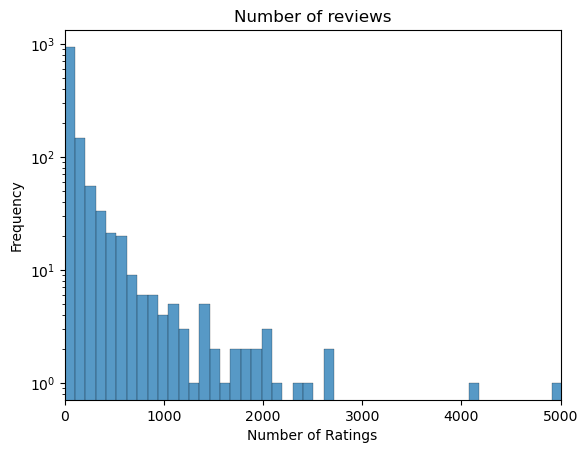

In [137]:
plt.figure()
sns.histplot(merged_df['CountsOfReview'], bins=200)
plt.yscale('log')
plt.xlim(0, 5000)
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.title("Number of reviews")

plt.savefig('reviewshist.png')

### Language Processing

We initialise a function that tokenises and lemmatises a given column. Afterwards, we apply this process to the relevant columns of our data frame.

In [110]:
# For ISBN and Publisher we can ignore these missing values as they are not really relevant to our analysis. 
# Language, however, can be quite important for a book recommendation system, as it directly affects user preferences 
# and accessibility. 

# Mode imputation for missing values:
# NOTE!!! We previously drop all the non-EN values. So we still have to look at this!!!!!
mode_language = merged_df['Language'].mode()[0]
merged_df['Language'].fillna(mode_language, inplace=True)

In [111]:
# Tokenizing and lemmatizing columns:
def tokenize_and_lemmatize(col):
    # ensures col is a string
    col = str(col)
    
    # Load English stopwords
    stop_words = set(stopwords.words('english'))
    
    # Initialize the Lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Tokenize the (lowered) column
    tokens = word_tokenize(col.lower())
    
    # Filter out stopwords and non-alphabetic characters
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    
    # Lemmatize each filtered token
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    
    return lemmatized_tokens

When applying the tokenization and lemmatization, we add them as new columns in the dataframe.

In [112]:
# Apply the tokenizing and lemmatization function to the "text" columns

merged_df['Processed_Name'] = merged_df['Name'].apply(tokenize_and_lemmatize)
merged_df['Processed_Authors'] = merged_df['Authors'].apply(tokenize_and_lemmatize)
merged_df['Processed_Description'] = merged_df['Description'].apply(tokenize_and_lemmatize)

# Not that relevant for our analysis but just in case we use it later on:
merged_df['Processed_Publisher'] = merged_df['Publisher'].apply(tokenize_and_lemmatize)
merged_df['Processed_Rating'] = merged_df['Rating_y'].apply(tokenize_and_lemmatize)

# Transforming the list
merged_df['Processed_Description'] = merged_df['Processed_Description'].apply(lambda x: ' '.join(x))

In [113]:
# There should be extra columns
print(f"The data frame now has {merged_df.shape[0]} rows and {merged_df.shape[1]} columns.")

The data frame now has 1273 rows and 26 columns.


### Training and Validation Sets

In [114]:
df_train_set, df_valid_set = train_test_split(merged_df, test_size=0.2, random_state=42, shuffle=True) # random state for reproducibility
print(f"The train data set now has {df_train_set.shape[0]} rows and {df_train_set.shape[1]} columns.")
print(f"The validation data set now has {df_valid_set.shape[0]} rows and {df_valid_set.shape[1]} columns.")

The train data set now has 1018 rows and 26 columns.
The validation data set now has 255 rows and 26 columns.


## Description Model (Anne Marijn & Clarice)

This model uses the description of a book to vectorize each book with the tfidf vectorizer.

In [115]:
# Imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [116]:
def calculate_description_similarity(df):
    # Initialising tfidf vectorization
    tf = TfidfVectorizer()
    
    # Fitting and transforming
    tfidf_matrix = tf.fit_transform(df['Processed_Description'])
    
    # Calculating cosine similarities of the tfidf vectors
    description_similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
    description_similarity_matrix = pd.DataFrame(description_similarity_matrix, 
                                                 index=df['Name'], 
                                                 columns=df['Name'])
    
    return description_similarity_matrix

We train the model and fill in the cosine similarity scores in a similarity matrix.

In [117]:
description_matrix = calculate_description_similarity(df_train_set)

In [118]:
description_matrix.head()

Name,"The Shining Ones (The Tamuli, #2)",Romeo and Juliet,The Ring of Brightest Angels Around Heaven: A Novella and Stories,"I is for Innocent (Kinsey Millhone, #9)",The Year of the Hare,The Greatest Generation Speaks: Letters and Reflections,Selected Short Stories,Essays,The Heart of Mid-Lothian,"Montmorency On The Rocks: Doctor, Aristocrat, Murderer? (Montmorency, #2)",...,"Shadowland (The Mediator, #1)",The Curious Incident of the Dog in the Night-Time,"Megan's Mate (The Calhouns, #5)",Always Room for One More,Pan,Tess of the D'Urbervilles,500 Handmade Books: Inspiring Interpretations of a Timeless Form,"Eat Pray Love: One Woman's Search for Everything Across Italy, India and Indonesia",The Orange Tree,"The Christmas Box (The Christmas Box, #1)"
Name,,,,,,,,,,,,,,,,,,,,,
"The Shining Ones (The Tamuli, #2)",1.000000,0.003481,0.000000,0.001895,0.0,0.000000,0.000000,0.007216,0.003057,0.000000,...,0.000000,0.002246,0.000000,0.004111,0.018123,0.0,0.002492,0.006307,0.000000,0.000000
Romeo and Juliet,0.003481,1.000000,0.030098,0.008105,0.0,0.020399,0.005705,0.004464,0.030270,0.000000,...,0.000000,0.003601,0.000000,0.002406,0.002455,0.0,0.024669,0.022290,0.047337,0.005058
The Ring of Brightest Angels Around Heaven: A Novella and Stories,0.000000,0.030098,1.000000,0.010206,0.0,0.006901,0.012072,0.062350,0.036775,0.015587,...,0.011340,0.042659,0.009609,0.000000,0.025982,0.0,0.013672,0.020951,0.041239,0.027975
"I is for Innocent (Kinsey Millhone, #9)",0.001895,0.008105,0.010206,1.000000,0.0,0.000000,0.007165,0.062256,0.016922,0.025443,...,0.027821,0.028545,0.012966,0.014380,0.018510,0.0,0.027989,0.031480,0.018182,0.004502
The Year of the Hare,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.015151,0.011463,0.010868,0.010059,...,0.000000,0.016437,0.015403,0.028471,0.014135,0.0,0.000000,0.015951,0.000000,0.020091


In [154]:
def description_recommendations(book_title, similarity_matrix, num_recommendations=5):
    print(f"According to the description model, the top {num_recommendations} most similar books for '{book_title}' are:\n")
    
    # Searching for corresponding similarity scores
    book_similarity_scores = description_matrix[book_title]
    
    # Sorting similarity scores
    similar_books_indices = book_similarity_scores.argsort()[::-1][1:num_recommendations+1]
    similar_books_titles = df_train_set.iloc[similar_books_indices]['Name'].tolist()
    
    # Printing top 5 similar books
    for i in range(len(similar_books_titles)):
        writer_name = merged_df.loc[merged_df['Name'] == similar_books_titles[i], 'Authors'].iloc[0]
        print(f"{i+1}: {similar_books_titles[i]}, written by {writer_name}")
        

In [155]:
description_recommendations("The House of the Vestals (Roma Sub Rosa, #6)", description_matrix)

According to the description model, the top 5 most similar books for 'The House of the Vestals (Roma Sub Rosa, #6)' are:

1: The Venus Throw (Roma Sub Rosa, #4), written by Steven Saylor
2: A Murder on the Appian Way (Roma Sub Rosa, #5), written by Steven Saylor
3: Vox, written by Nicholson Baker
4: Empire, written by H. Beam Piper
5: Kiss of the Night (Dark-Hunter, #4), written by Sherrilyn Kenyon


## Rating model (Tereza)

In [121]:
# Calculate cosine similarity between book ratings
def calculate_rating_similarity(merged_df):
    # Convert rating strings to numeric values
    merged_df['Rating_numeric'] = merged_df['Processed_Rating'].apply(lambda x: 5 if 'amazing' in x else (4 if 'really, liked' in x else (3 if 'liked' in x else (2 if 'ok' in x else 1))))
    
    # Calculate cosine similarity matrix
    ratings_matrix = merged_df.pivot_table(index='userID', columns='bookID', values='Rating_numeric').fillna(0)
    rating_similarity_matrix = cosine_similarity(ratings_matrix.T)
    
    return rating_similarity_matrix

In [122]:
merged_df.head()

,bookID,Name,Authors,ISBN,Rating_x,PublishYear,PublishMonth,PublishDay,Publisher,RatingDist5,...,Language,pagesNumber,Description,userID,Rating_y,Processed_Name,Processed_Authors,Processed_Description,Processed_Publisher,Processed_Rating
3,600057,Justice at Nuremberg,Robert E. Conot,0881840327,4.15,1993,28,1,Basic Books,5:88,...,eng,624,"Here, for the first time in one volume, is the...",9859,liked it,"[justice, nuremberg]","[robert, conot]",first time one volume full story crime committ...,"[basic, book]",[liked]
8,600157,Monsignor Quixote,Graham Greene,0370309235,3.91,1982,1,1,Putnam Aeronautical Books,5:925,...,eng,220,<p><b>A morally complex and mature work from a...,4693,it was ok,"[monsignor, quixote]","[graham, greene]",p b morally complex mature work modern master ...,"[putnam, aeronautical, book]",[ok]
131,600241,Stick,Steve Breen,0803731248,4.03,2007,1,3,Dial,5:104,...,eng,40,Stick is a frog who likes to do things on his ...,10378,it was amazing,[stick],"[steve, breen]",stick frog like thing help mom one day get car...,[dial],[amazing]
371,600349,Dangerous Visions,Harlan Ellison,0743452615,4.19,2002,1,10,iBooks,5:3788,...,eng,592,The most honored anthology of fantastic fictio...,192,it was amazing,"[dangerous, vision]","[harlan, ellison]",honored anthology fantastic fiction ever publi...,[ibooks],[amazing]
379,600404,Krik? Krak!,Edwidge Danticat,067976657X,4.12,1996,2,4,Vintage,5:2711,...,eng,224,"At an astonishingly young age, Edwidge Dantica...",3184,it was amazing,"[krik, krak]","[edwidge, danticat]",astonishingly young age edwidge danticat becom...,[vintage],[amazing]


In [123]:
# Weighted similarity scores based on number of written reviews
def calculate_weighted_similarity(similarity_matrix, merged_df):
    # Get number of written reviews for each book
    written_reviews = merged_df.groupby('bookID')['CountsOfReview'].sum()
    
    # Normalize written reviews
    max_reviews = written_reviews.max()
    written_reviews_norm = written_reviews / max_reviews
   
    # Apply weights to similarity matrix
    weighted_similarity_matrix = similarity_matrix * written_reviews_norm.values.reshape(-1, 1)
    
    return weighted_similarity_matrix

In [124]:
# Calculate similarity matrix
rating_similarity_matrix = calculate_rating_similarity(df_train_set)

# Calculate weighted similarity matrix
weighted_similarity_matrix = calculate_weighted_similarity(rating_similarity_matrix, df_train_set)

Since this model is designed a bit differently, we use a different helper function to print the recommended books.

In [186]:
def recommend_books(book_title, weighted_similarity_matrix, num_recommendations=5):
    print(f"According to the ratings model, the top {num_recommendations} most similar books for '{book_title}' are:\n")

    # Find the index of the given book title
    book_index = df_train_set[df_train_set['Name'] == book_title].index[0]
    
    # Get the similarity scores for the given book
    book_similarity_scores = weighted_similarity_matrix[book_index]
    
    # Sort the similarity scores in descending order and get top N similar books
    similar_books_indices = book_similarity_scores.argsort()[::-1][1:num_recommendations+1]
    
    # Exclude the input book's index from the results
    similar_books_indices = similar_books_indices[similar_books_indices != book_index]
    similar_books_titles = df_train_set.iloc[similar_books_indices]['Name'].tolist()
    
    return similar_books_titles

In [180]:
# Example: Recommend 5 books similar to "A Short History of Nearly Everything"
recommendations = recommend_books("Stick", weighted_similarity_matrix)
print("Recommended Books:")
for i, book in enumerate(recommendations, 1):
    print(f"{i}. {book}")

According to the ratings model, the top 6 most similar books for 'Stick' are:

Recommended Books:
1. The Christmas Box (The Christmas Box, #1)
2. Guardian Angel (V.I. Warshawski, #7)
3. The Restaurant at the End of the Universe (Hitchhiker's Guide, #2)
4. Expecting Someone Taller
5. Blade Dancer


## Combination Model (Andrea)

This model combines the description and rating model.

In [127]:
from sklearn.preprocessing import MinMaxScaler

In [128]:
# The description similarity and weighted rating similarity matrices should be normalized to ensure they contribute equally 
# to the final recommendation score
def normalize_similarity_matrix(matrix):
    scaler = MinMaxScaler()
    normalized_matrix = scaler.fit_transform(matrix)
    return normalized_matrix

In [129]:
# Weighted average method to combine these matrices
def combine_matrices(desc_matrix, rating_matrix, alpha=0.5):
    # Ensure alpha is between 0 and 1
    if not 0 <= alpha <= 1:
        raise ValueError("Alpha should be between 0 and 1")

    # Normalize matrices
    normalized_desc = normalize_similarity_matrix(desc_matrix)
    normalized_rating = normalize_similarity_matrix(rating_matrix)

    # Combine the matrices
    combined_matrix = alpha * normalized_desc + (1 - alpha) * normalized_rating
    return combined_matrix

In [130]:
def combined_recommendations(book_title, combined_matrix, books_df, num_recommendations=5):
    if book_title not in books_df['Name'].values:
        raise ValueError("Book title not found in the dataset")

    # Retrieve book index
    idx = books_df[books_df['Name'] == book_title].index[0]
    
    # Similarity scores
    book_similarity_scores = combined_matrix[idx]

    # Sort the books based on the combined similarity scores
    similar_books_indices = book_similarity_scores.argsort()[::-1][1:num_recommendations+1]
    similar_books_titles = df_train_set.iloc[similar_books_indices]['Name'].tolist()
    return similar_books_titles

In [131]:
# Example Usage
alpha_value = 0.5  # Both of them have equal weight - we can experiment adjusting this value
combined_similarity_matrix = combine_matrices(description_matrix.values, weighted_similarity_matrix, alpha=alpha_value)

# Ensure all indices are within the valid range
df_train_set.reset_index(drop=True, inplace=True)
valid_indices = df_train_set.index[df_train_set.index < len(combined_similarity_matrix)]
df_valid = df_train_set.loc[valid_indices]
# Now, df_valid contains only rows that correspond to valid indices in our matrix

recommended_books = combined_recommendations("Stick", combined_similarity_matrix, df_train_set, num_recommendations=5)
print("Recommended Books:")
for i, book in enumerate(recommended_books, 1):
    print(f"{i}. {book}")

Recommended Books:
1. Mr. Greedy
2. Daring to Dream (Dream Trilogy, #1)
3. Book of Shadows (Sweep, #1)
4. I Was a Really Good Mom Before I Had Kids: Reinventing Modern Motherhood
5. Dead and Alive (Dean Koontz's Frankenstein #3)


### Model Evaluation:

For our model evaluation, we consider one random book from our dataset as depicted in the code block below (commented out). Moreover, we also chose one book of the Harry Potter series to examine whether the  model would recommend other Harry Potter books. We find this a very appropriate way of assessing the outcome of the model.

In [132]:
# random_books = random.sample(list(df_train_set["Name"]), 1)
# print(random_books)

**Evaluation Random Book**

The result of this code was 'The Devil's Dictionary', written by Ambrose Bierce.

In [164]:
# Description model:
description_recommendations("The Devil's Dictionary", description_matrix)

According to the description model, the top 5 most similar books for 'The Devil's Dictionary' are:

1: The Describer's Dictionary: A Treasury of Terms & Literary Quotations, written by David Grambs
2: A Concise Chinese-English Dictionary for Lovers, written by Xiaolu Guo
3: Blithe Spirit, written by Noël Coward
4: The Importance of Being Earnest, written by Oscar Wilde
5: Essays, written by George Orwell


In [185]:
# Ratings model:
recommendations = recommend_books("The Devil's Dictionary", weighted_similarity_matrix, num_recommendations=5)
for i, book in enumerate(recommendations, 1):
    writer_name = merged_df.loc[merged_df['Name'] == book, 'Authors'].iloc[0]
    print(f"{i}. {book}, written by {writer_name}")

According to the ratings model, the top 6 most similar books for 'The Devil's Dictionary' are:

1. Dancing Carl, written by Gary Paulsen
2. Seven Gothic Tales, written by Isak Dinesen
3. Pawn of Prophecy (The Belgariad, #1), written by David Eddings
4. The Real All Americans: The Team That Changed a Game, a People, a Nation, written by Sally Jenkins
5. Kampung Boy, written by Lat


In [172]:
# Combined model:
alpha_value = 0.5
recommended_books = combined_recommendations("The Devil's Dictionary", combined_similarity_matrix, df_train_set, num_recommendations=5)
print("According to the combined model, the top 5 most similar books for 'The Devil's Dictionary' are:\n")
for i, book in enumerate(recommended_books, 1):
    writer_name = merged_df.loc[merged_df['Name'] == book, 'Authors'].iloc[0]
    print(f"{i}. {book}, written by {writer_name}")

According to the combined model, the top 5 most similar books for 'The Devil's Dictionary' are:

1. Grendel, written by John Gardner
2. The Real All Americans: The Team That Changed a Game, a People, a Nation, written by Sally Jenkins
3. The Greatest Generation Speaks: Letters and Reflections, written by Tom Brokaw
4. The Describer's Dictionary: A Treasury of Terms & Literary Quotations, written by David Grambs
5. Seven Gothic Tales, written by Isak Dinesen


**Evaluation of Harry Potter book**

For the second evaluation, we chose one of the Harry Potter (by J.K. Rowling) books to check whether the models would recommend any other books os the series.

In [167]:
# Let's see which books are available in our data set.
for name in df_train_set['Name']:
    if "Harry Potter" in name:
        print(name)

Harry Potter and the Philosopher's Stone (Harry Potter, #1)
Harry Potter and the Half-Blood Prince (Harry Potter, #6)
Harry Potter and the Chamber of Secrets (Harry Potter, #2)
Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)


Given these results, we decide to evaluate the recommendations of Harry Potter and the Philosopher's Stone.

In [168]:
# Description Model:
description_recommendations("Harry Potter and the Philosopher's Stone (Harry Potter, #1)", description_matrix)

According to the description model, the top 5 most similar books for 'Harry Potter and the Philosopher's Stone (Harry Potter, #1)' are:

1: Harry Potter and the Chamber of Secrets (Harry Potter, #2), written by J.K. Rowling
2: Harry Potter and the Prisoner of Azkaban (Harry Potter, #3), written by J.K. Rowling
3: Harry Potter and the Half-Blood Prince (Harry Potter, #6), written by J.K. Rowling
4: Wish List, written by Lisa Kleypas
5: Essays, written by George Orwell


In [187]:
# Ratings Model:
recommendations = recommend_books("Harry Potter and the Philosopher's Stone (Harry Potter, #1)", weighted_similarity_matrix, num_recommendations=5)
for i, book in enumerate(recommendations, 1):
    writer_name = merged_df.loc[merged_df['Name'] == book, 'Authors'].iloc[0]
    print(f"{i}. {book}, written by {writer_name}")

According to the ratings model, the top 5 most similar books for 'Harry Potter and the Philosopher's Stone (Harry Potter, #1)' are:

1. The Illearth War (The Chronicles of Thomas Covenant the Unbeliever, #2), written by Stephen R. Donaldson
2. A Canticle for Leibowitz (St. Leibowitz, #1), written by Walter M. Miller Jr.
3. Modern Man in Search of a Soul, written by C.G. Jung
4. Critical Discourse Analysis: The Critical Study of Language, written by Norman Fairclough
5. Cancer Ward, written by Aleksandr Solzhenitsyn


In [170]:
# Combination model:
alpha_value = 0.5
recommended_books = combined_recommendations("Harry Potter and the Philosopher's Stone (Harry Potter, #1)", combined_similarity_matrix, df_train_set, num_recommendations=5)
print("According to the combined model, the top 5 most similar books for 'The Devil's Dictionary' are:\n")

for i, book in enumerate(recommended_books, 1):
    writer_name = merged_df.loc[merged_df['Name'] == book, 'Authors'].iloc[0]
    print(f"{i}. {book}, written by {writer_name}")

According to the combined model, the top 5 most similar books for 'The Devil's Dictionary' are:

1. Harry Potter and the Chamber of Secrets (Harry Potter, #2), written by J.K. Rowling
2. Harry Potter and the Prisoner of Azkaban (Harry Potter, #3), written by J.K. Rowling
3. Harry Potter and the Half-Blood Prince (Harry Potter, #6), written by J.K. Rowling
4. Wish List, written by Lisa Kleypas
5. Essays, written by George Orwell
